<a href="https://colab.research.google.com/github/N47IN/Object-Detection-and-Image-Processing/blob/main/nlf_pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# PyTorch version
! git clone https://github.com/isarandi/nlf.git
! mkdir -p models
! wget -q -O models/nlf_l_multi.torchscript https://bit.ly/nlf_l_pt
! pip install pickle5
! pip install matplotlib
!pip install imageio

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pickle5 as pickle
from matplotlib.animation import FuncAnimation

model = torch.jit.load('models/nlf_l_multi.torchscript').cuda().eval()


fatal: destination path 'nlf' already exists and is not an empty directory.


Processing frame 1/55
Processing frame 2/55
Processing frame 3/55
Processing frame 4/55
Processing frame 5/55
Processing frame 6/55
Processing frame 7/55
Processing frame 8/55
Processing frame 9/55
Processing frame 10/55
Processing frame 11/55
Processing frame 12/55
Processing frame 13/55
Processing frame 14/55
Processing frame 15/55
Processing frame 16/55
Processing frame 17/55
Processing frame 18/55
Processing frame 19/55


<ipython-input-3-4b9ffbf971dc>:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8))


Processing frame 20/55
Processing frame 21/55
Processing frame 22/55
Processing frame 23/55
Processing frame 24/55
Processing frame 25/55
Processing frame 26/55
Processing frame 27/55
Processing frame 28/55
Processing frame 29/55
Processing frame 30/55
Processing frame 31/55
Processing frame 32/55
Processing frame 33/55
Processing frame 34/55
Processing frame 35/55
Processing frame 36/55
Processing frame 37/55
Processing frame 38/55
Processing frame 39/55
Processing frame 40/55
Processing frame 41/55
Processing frame 42/55
Processing frame 43/55
Processing frame 44/55
Processing frame 45/55
Processing frame 46/55
Processing frame 47/55
Processing frame 48/55
Processing frame 49/55
Processing frame 50/55
Processing frame 51/55
Processing frame 52/55
Processing frame 53/55
Processing frame 54/55
Processing frame 55/55


<ipython-input-3-4b9ffbf971dc>:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


NameError: name 'os' is not defined

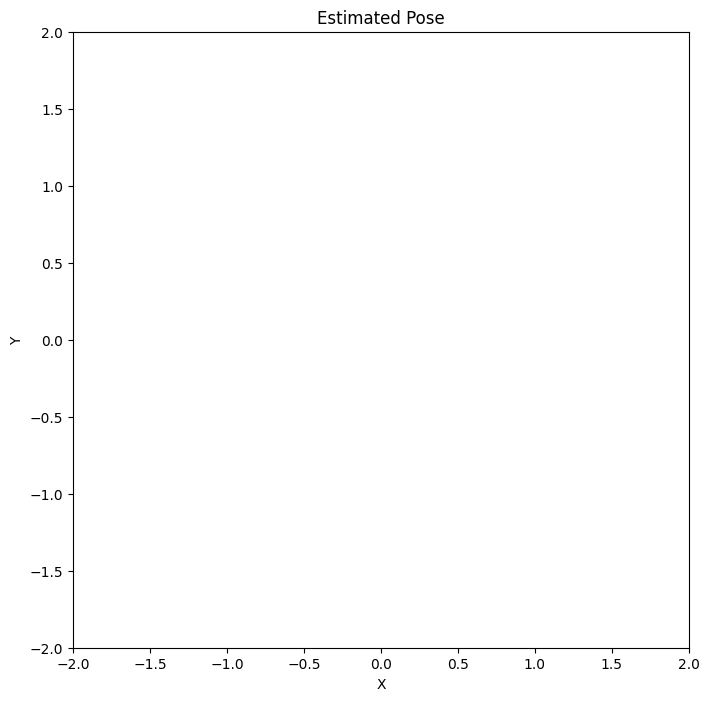

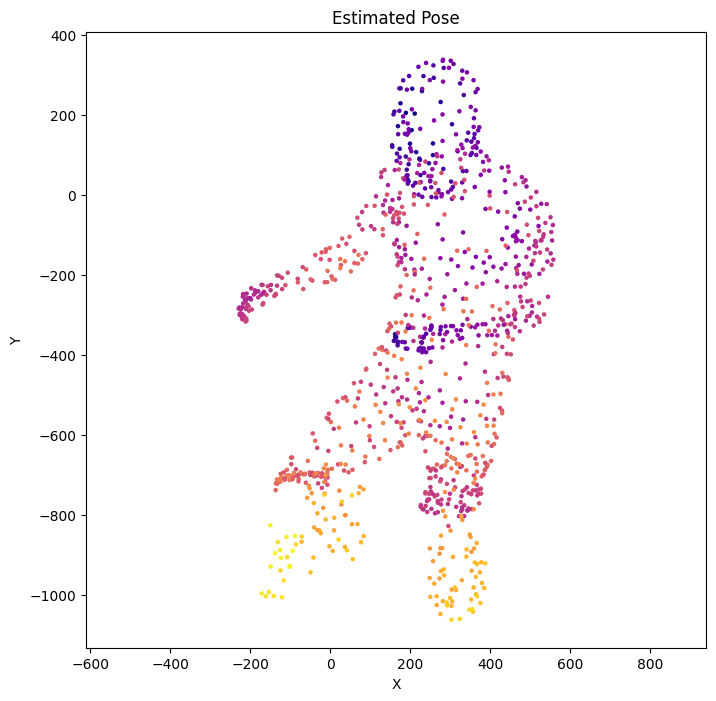

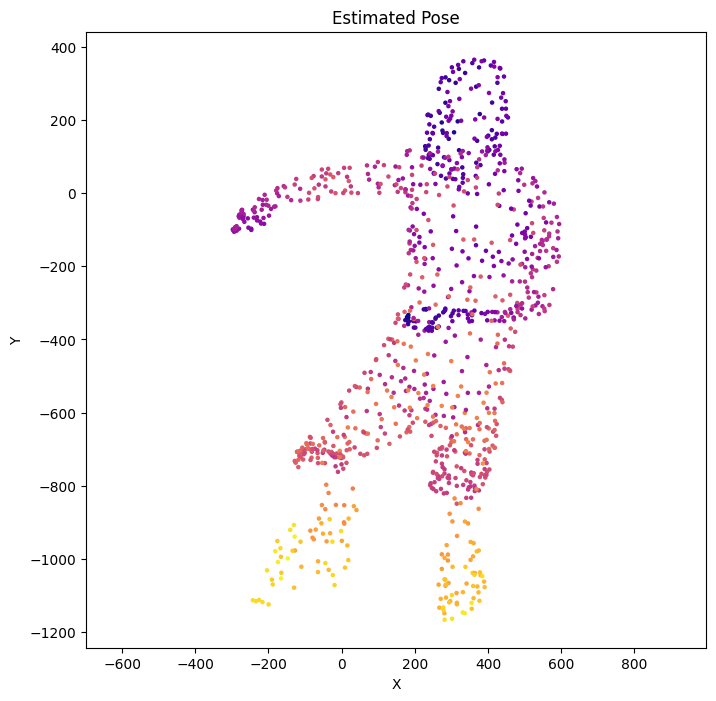

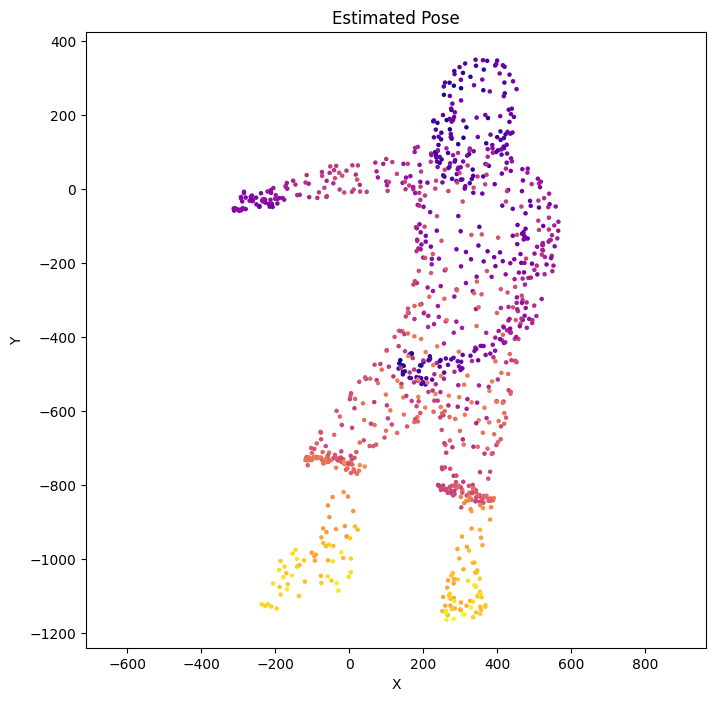

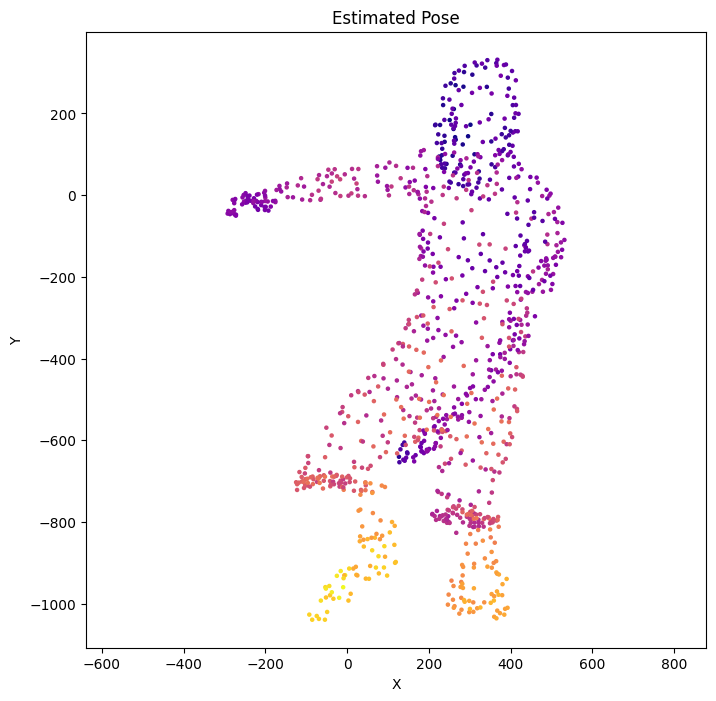

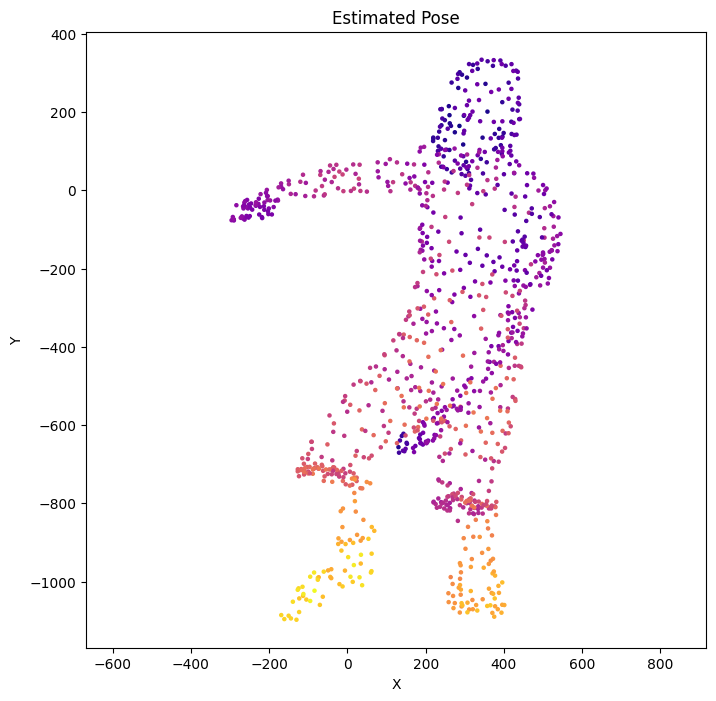

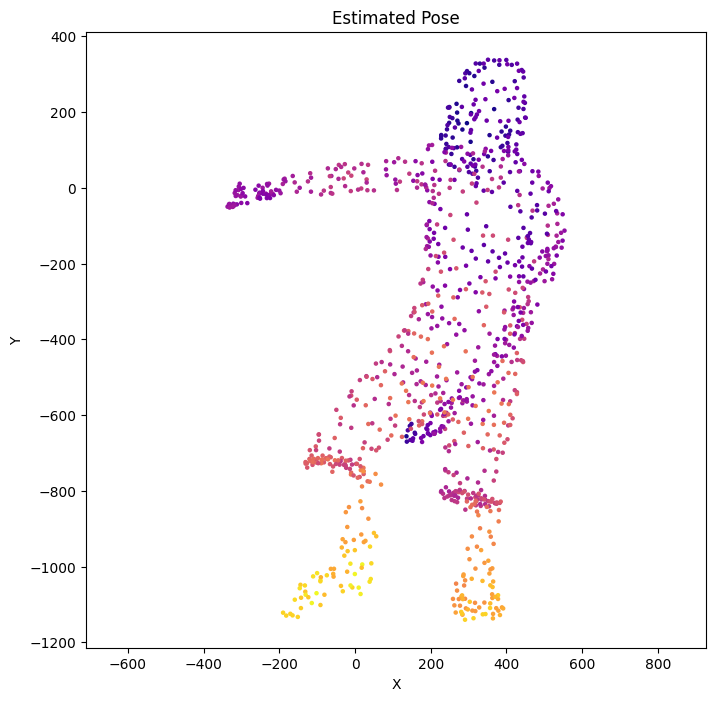

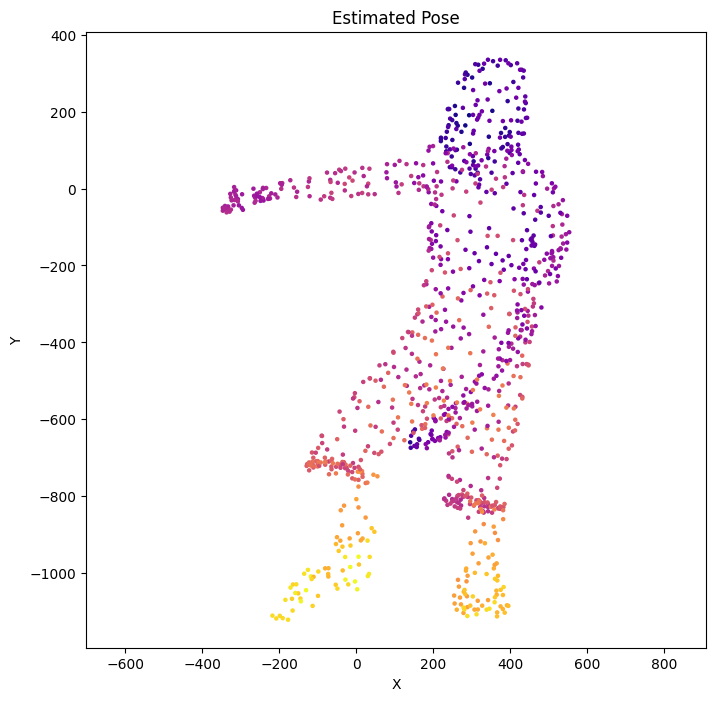

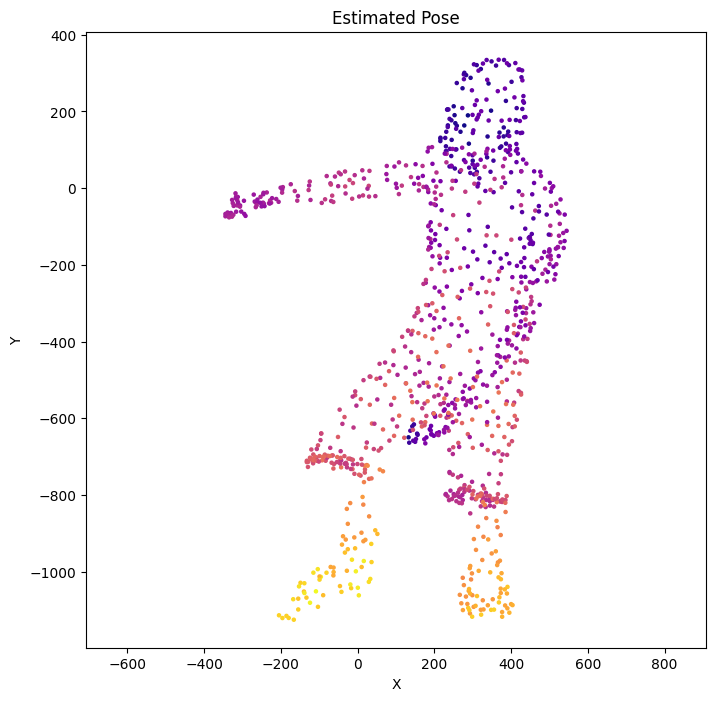

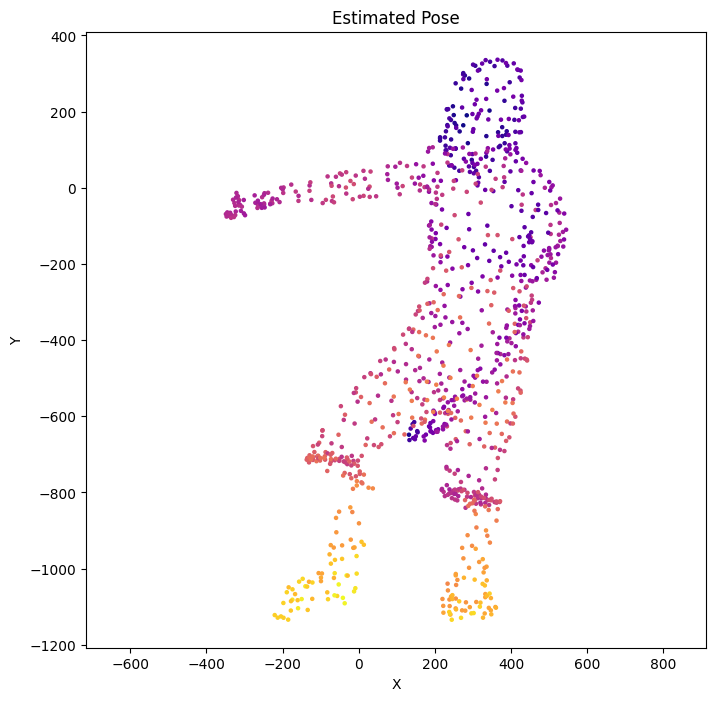

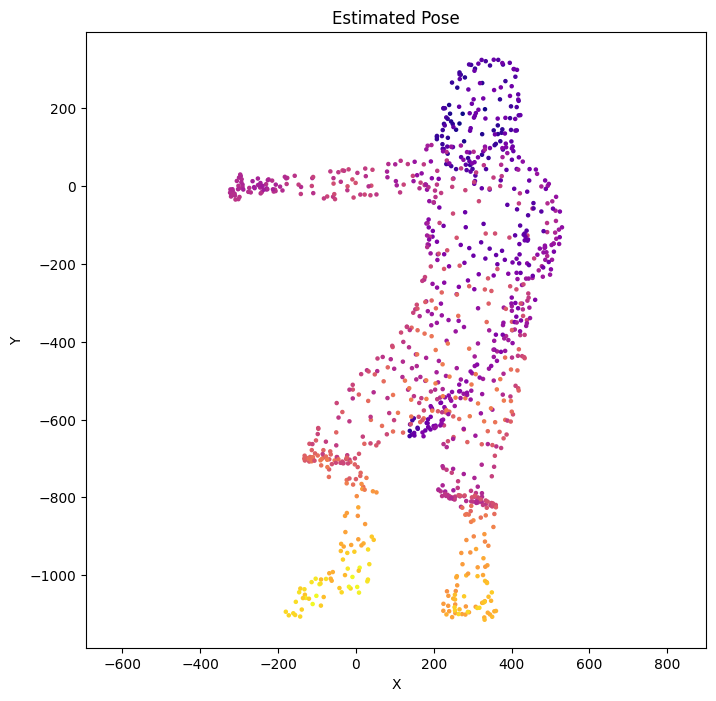

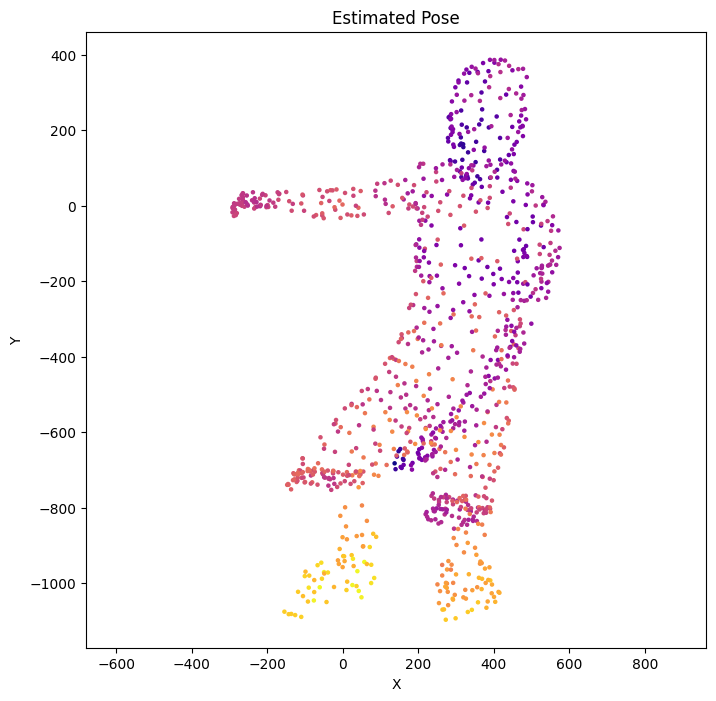

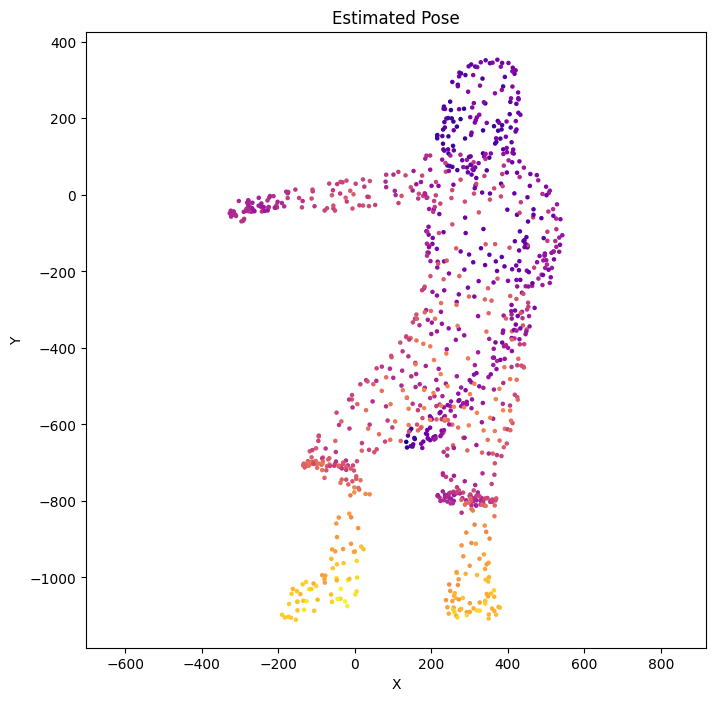

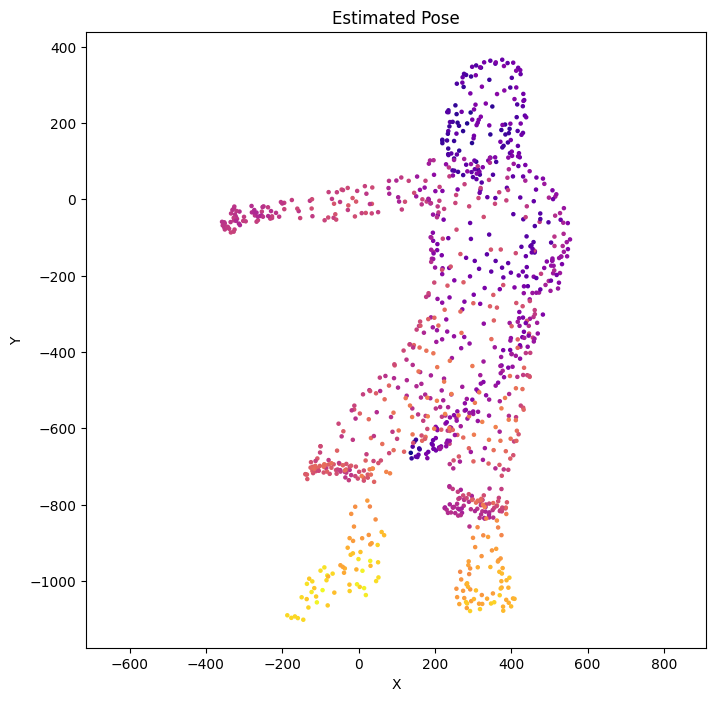

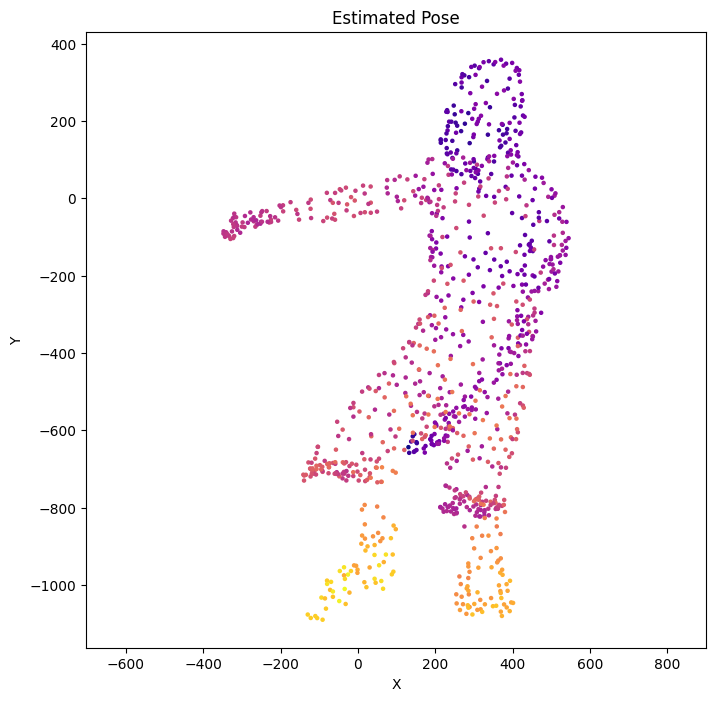

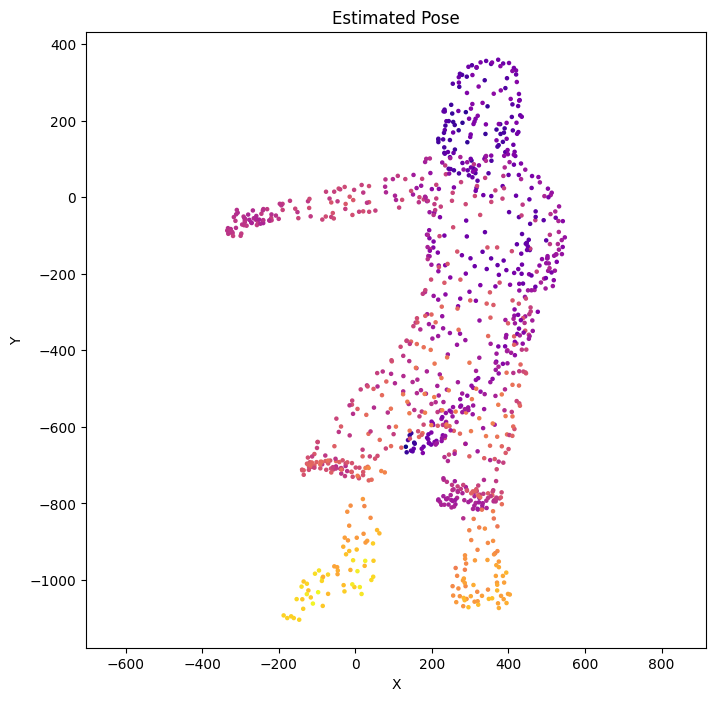

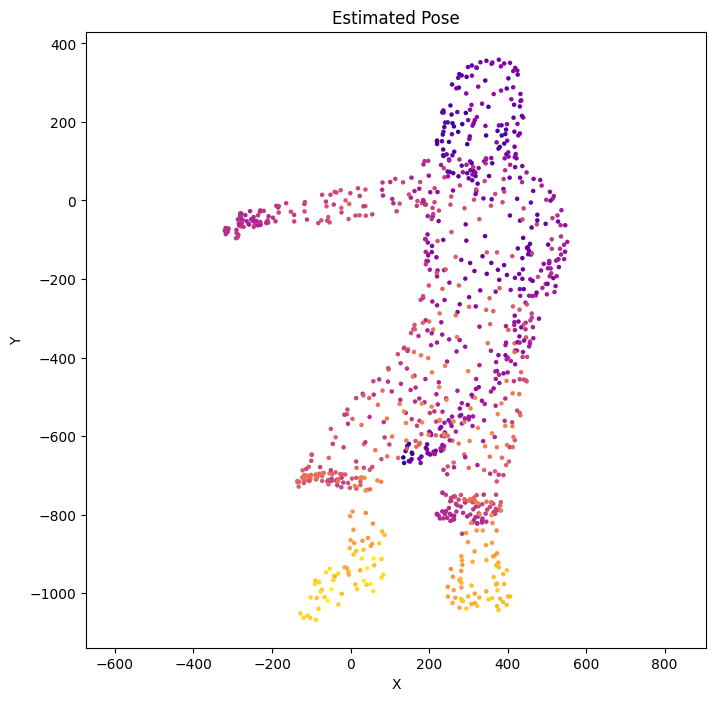

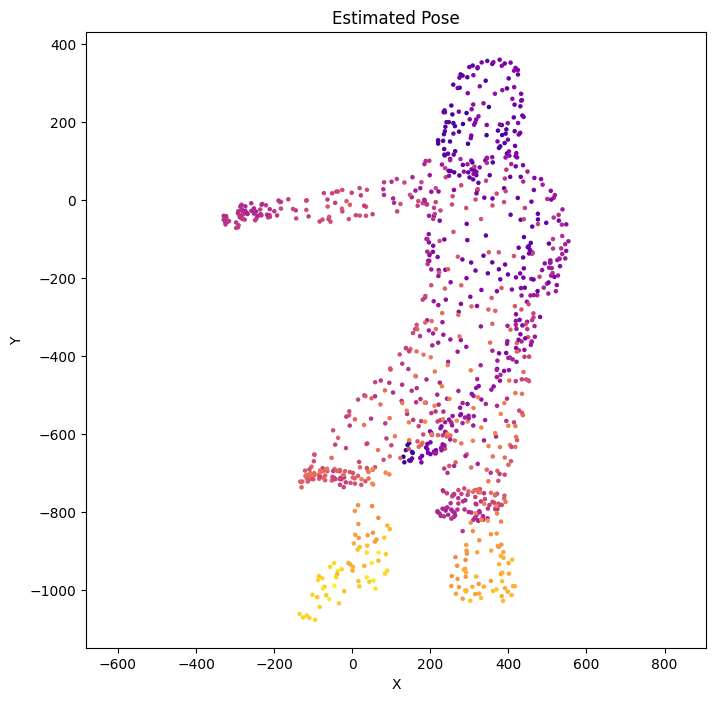

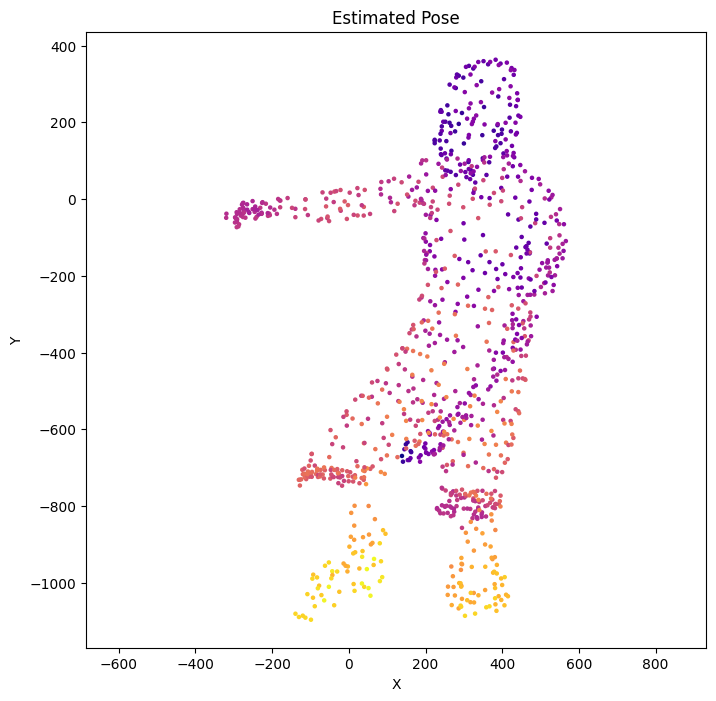

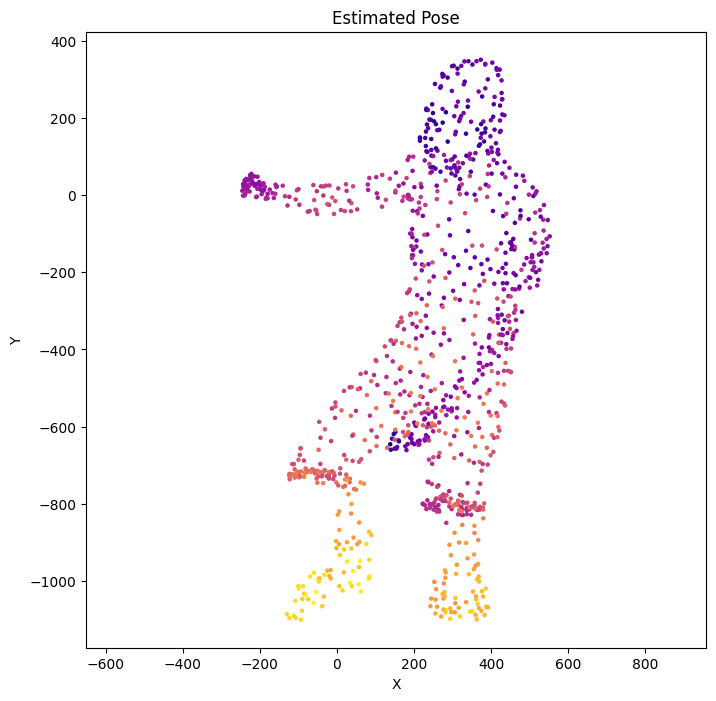

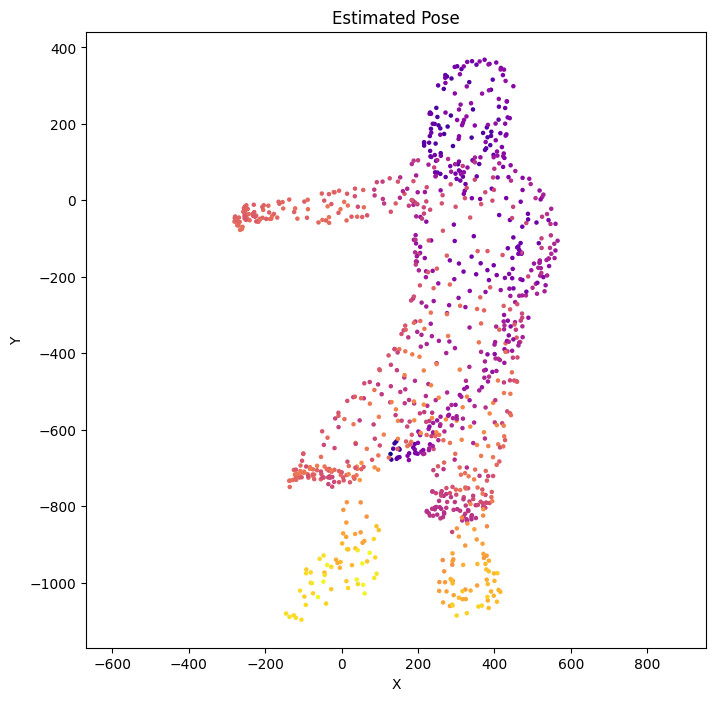

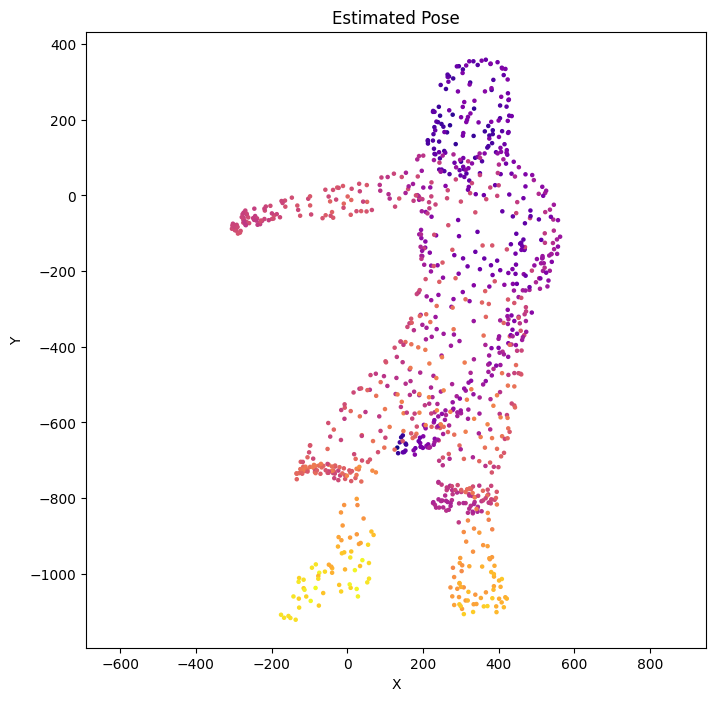

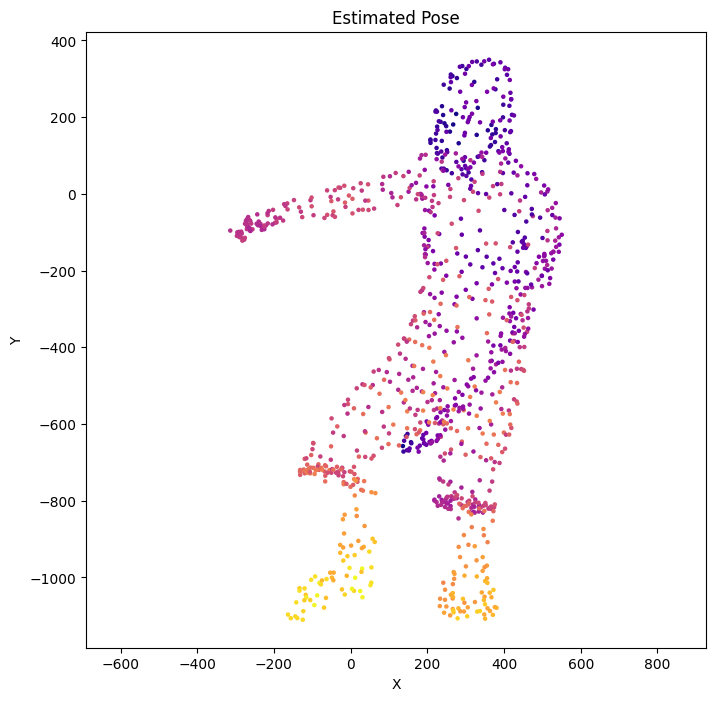

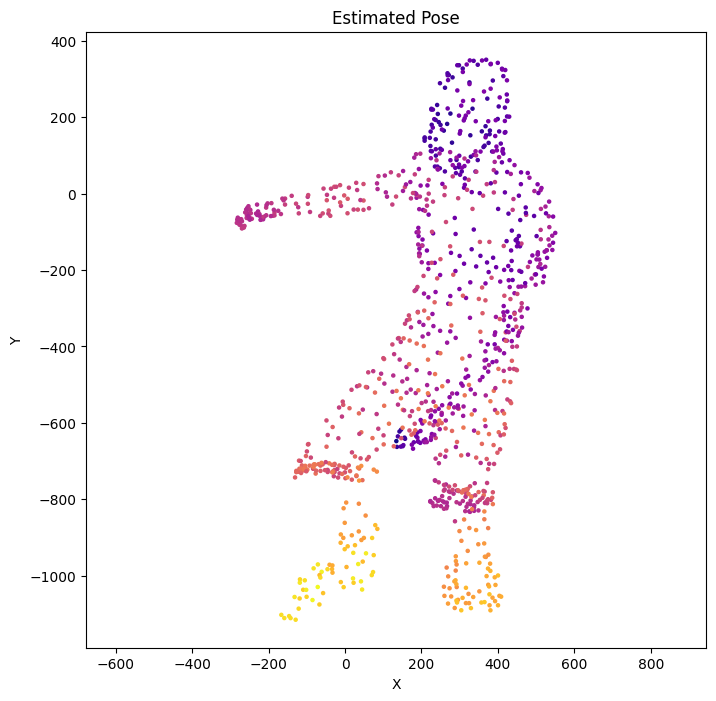

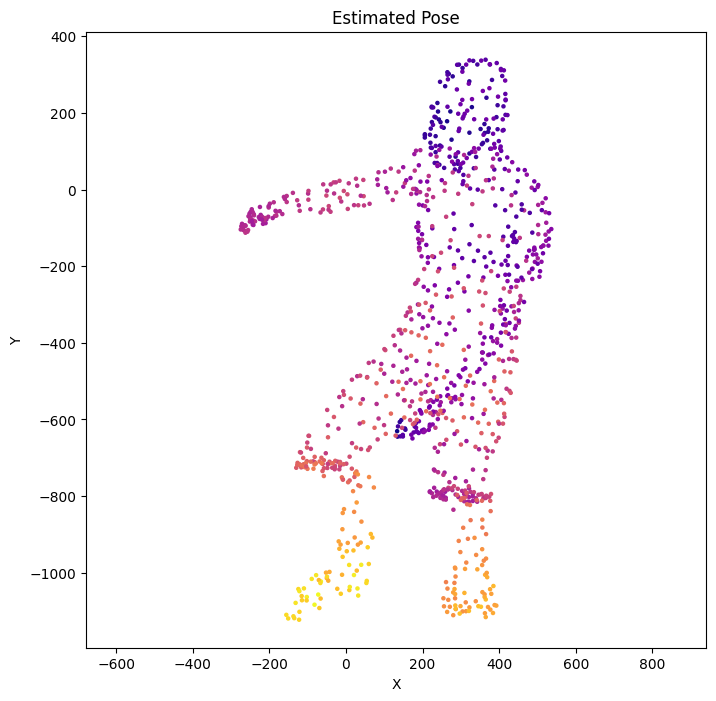

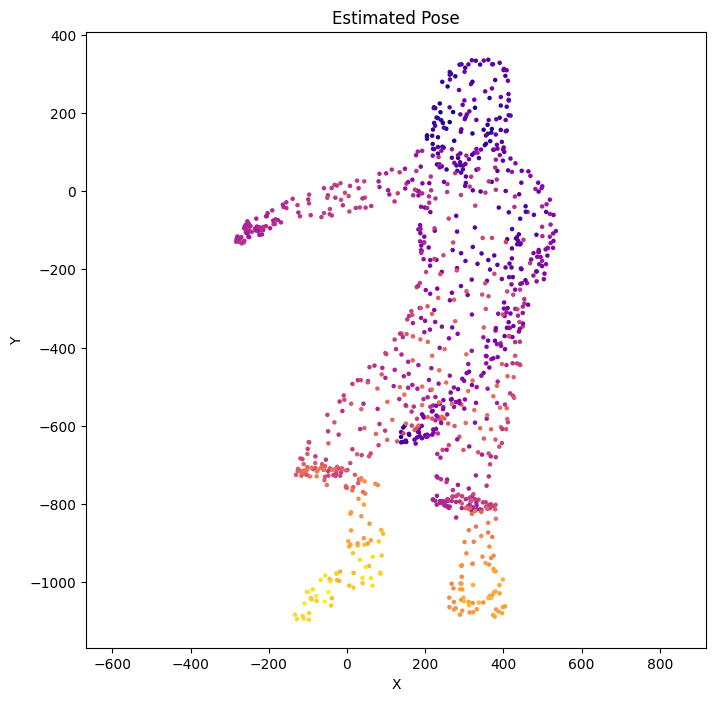

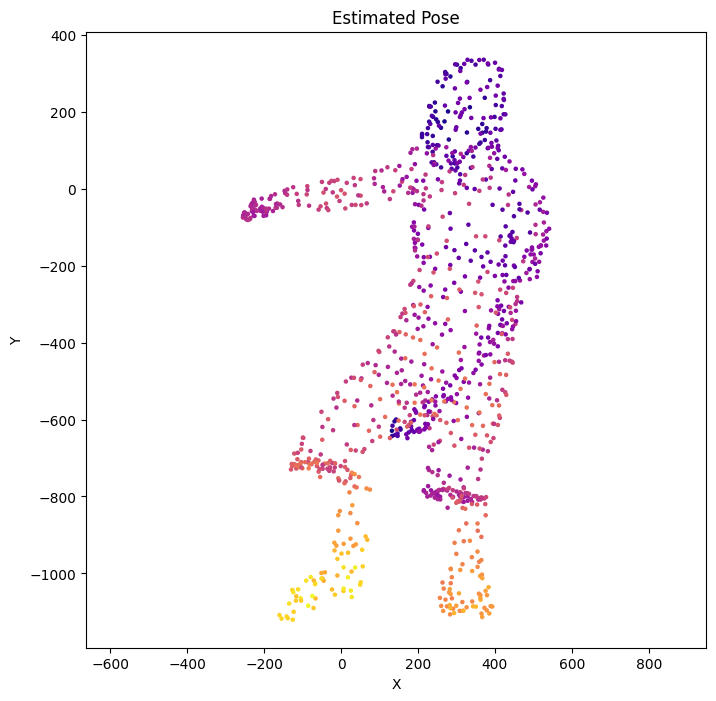

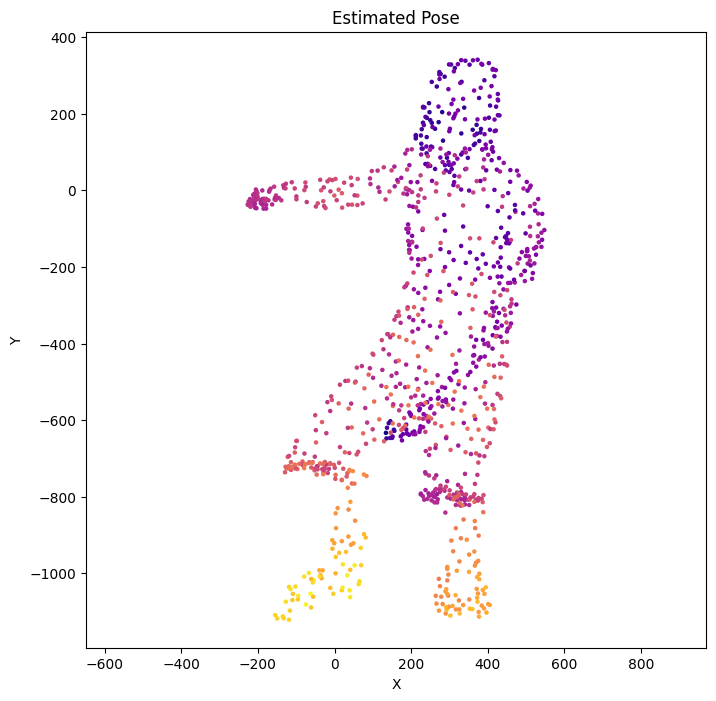

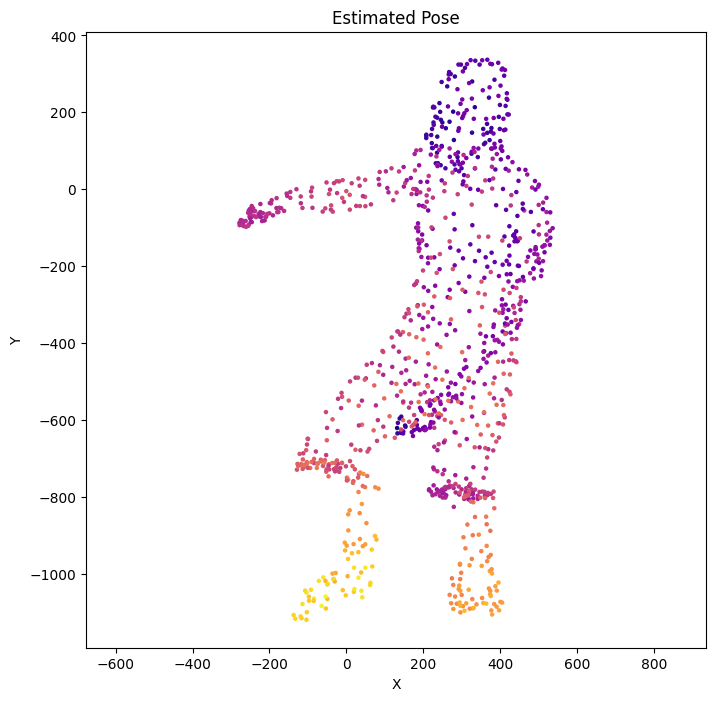

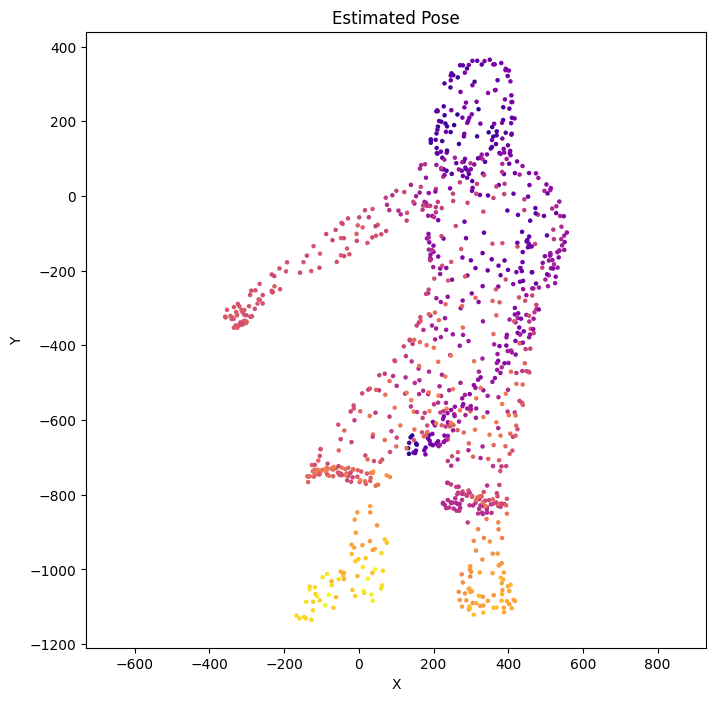

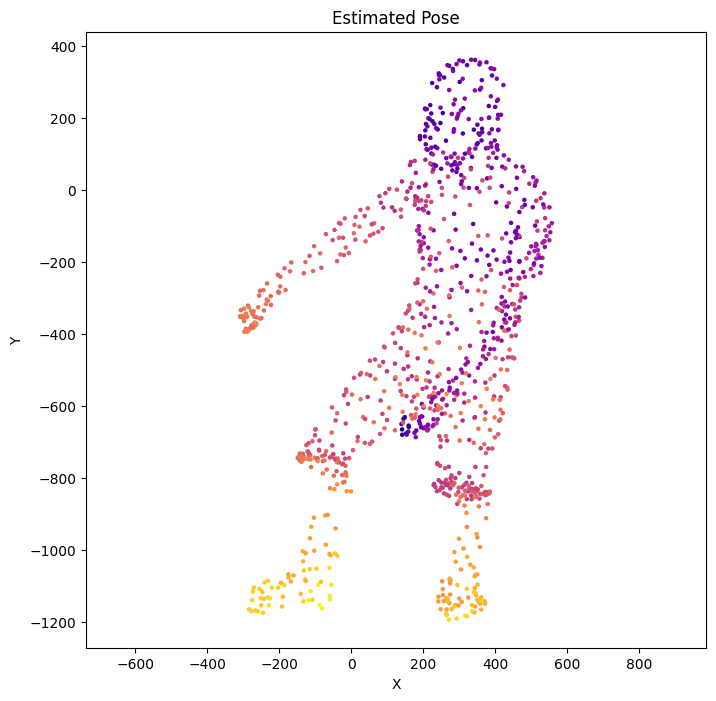

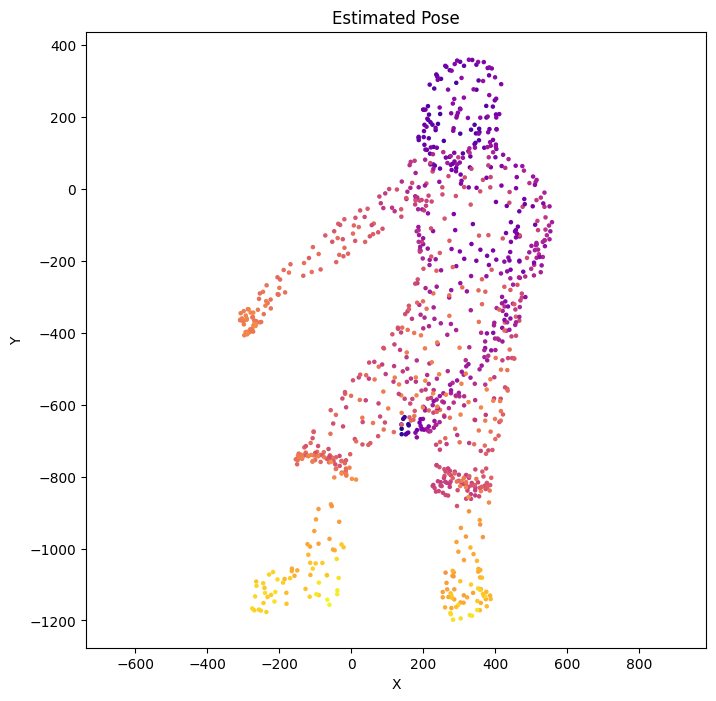

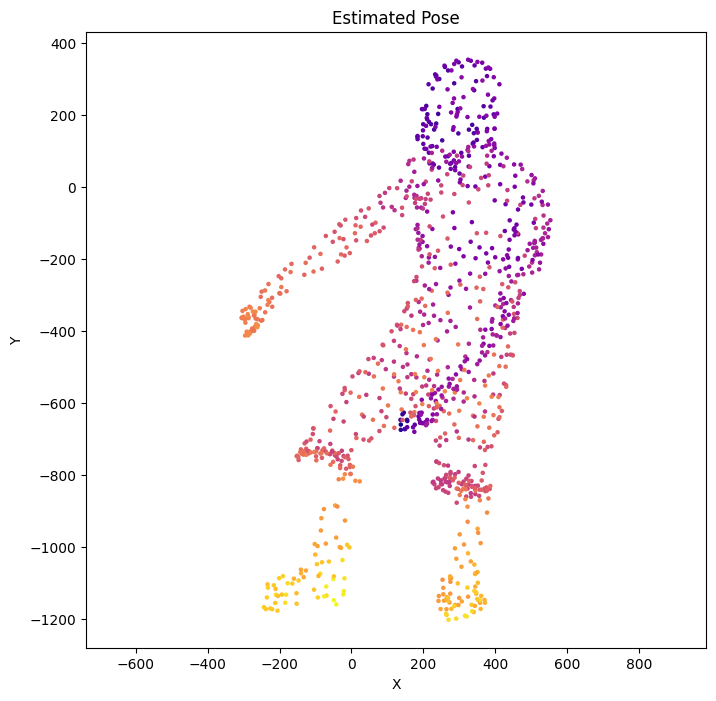

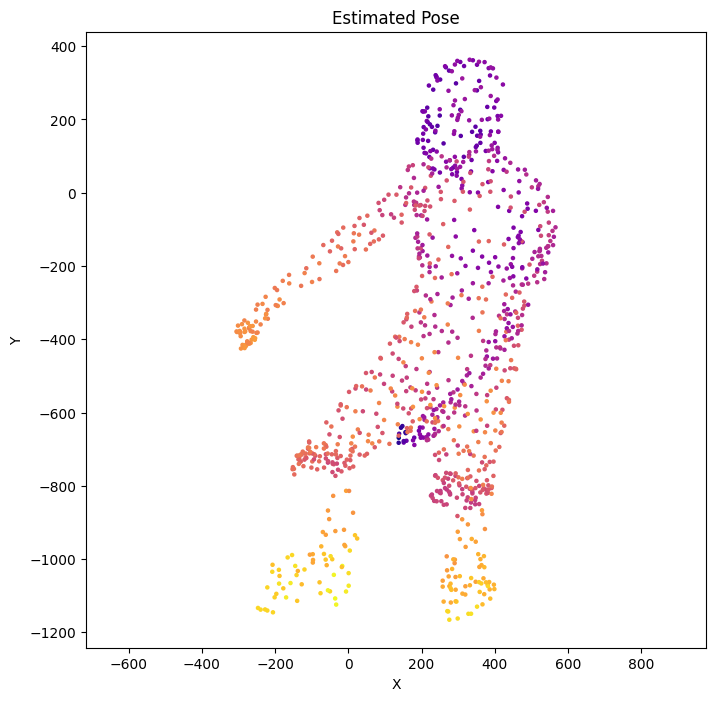

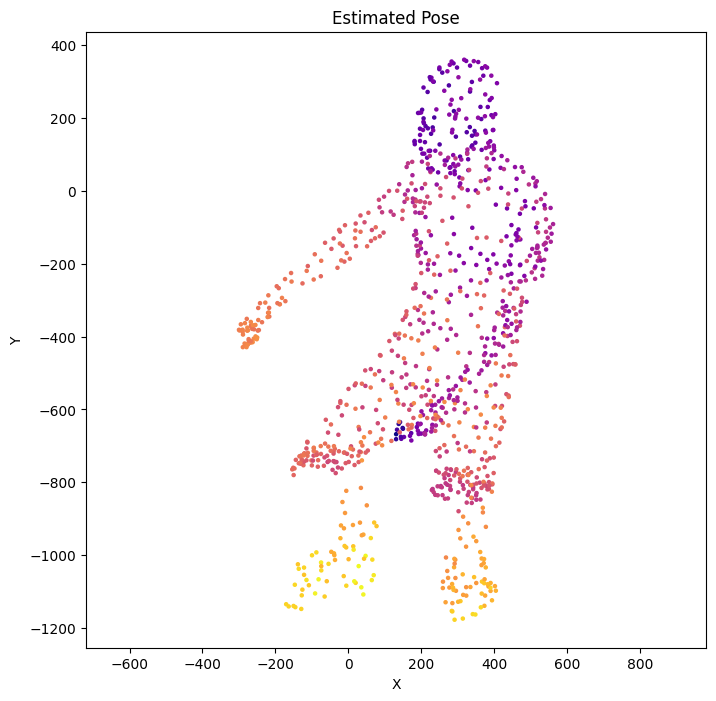

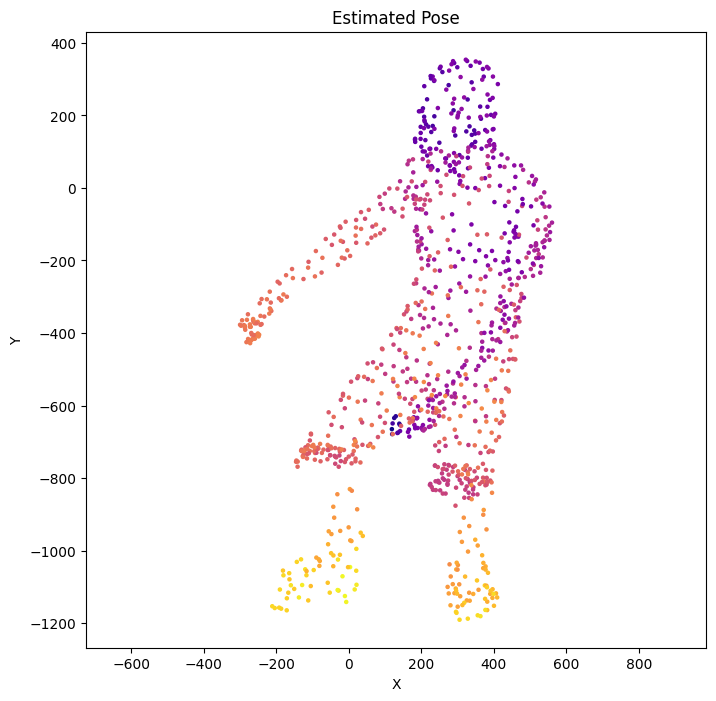

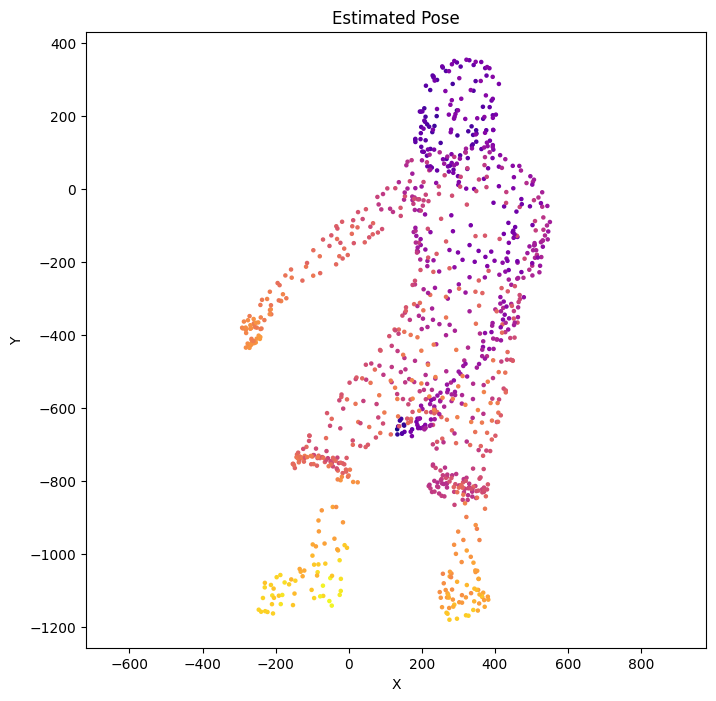

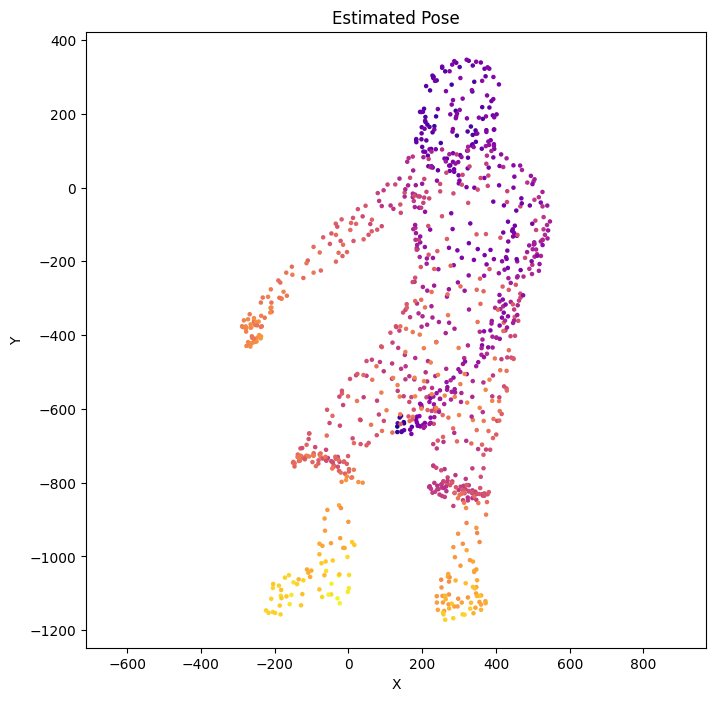

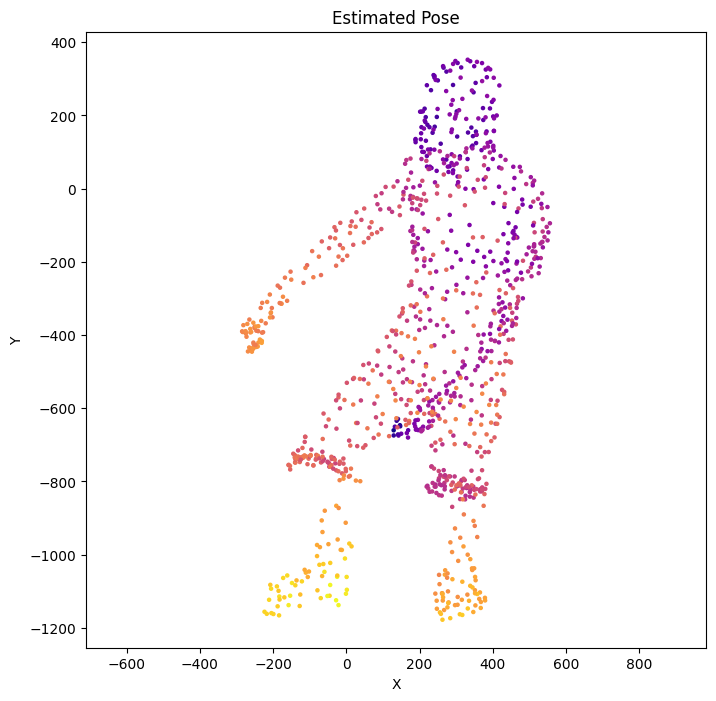

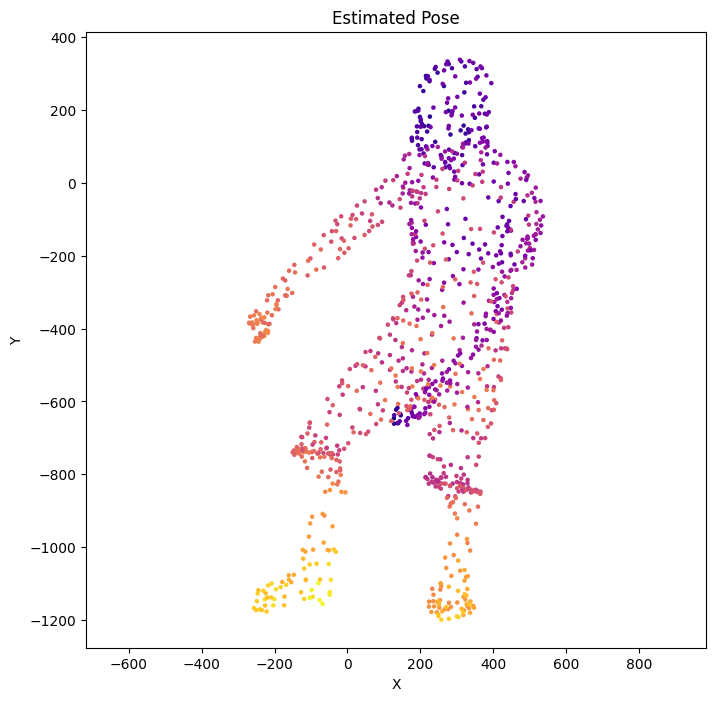

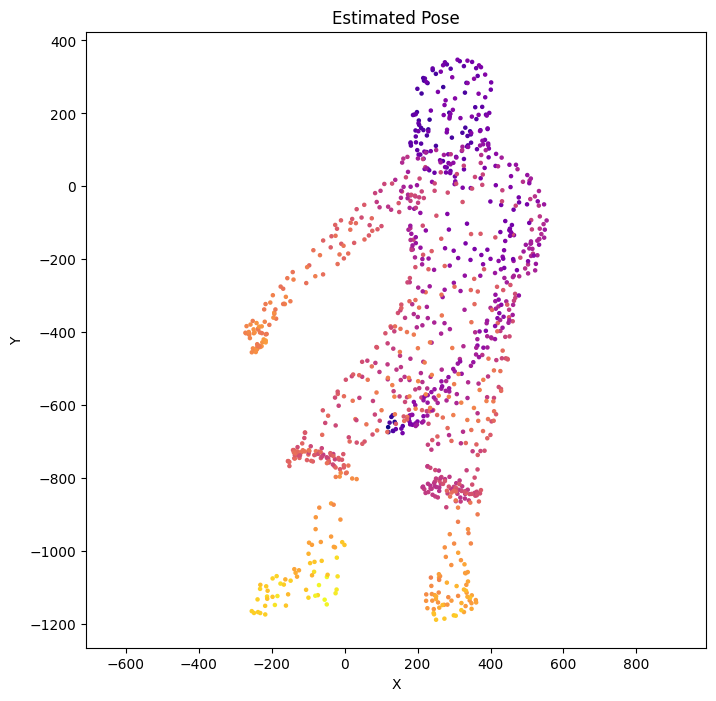

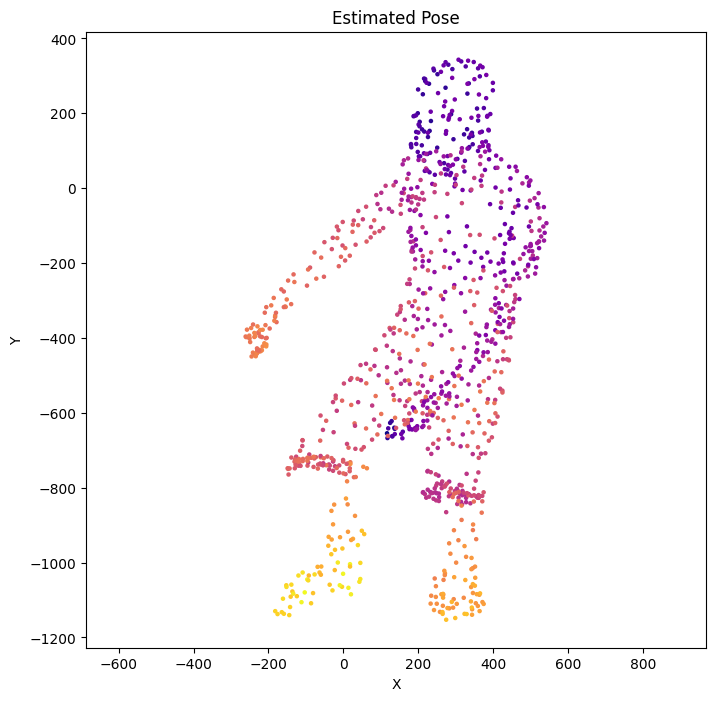

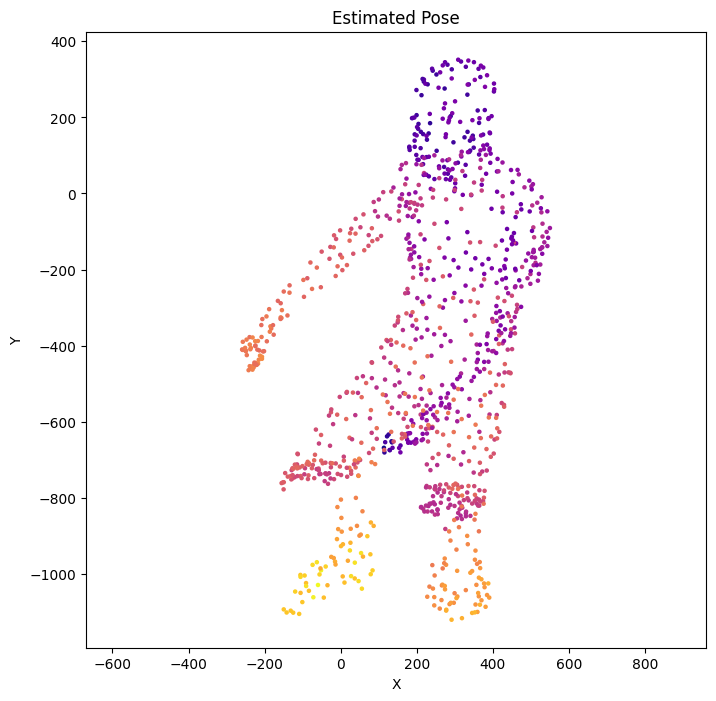

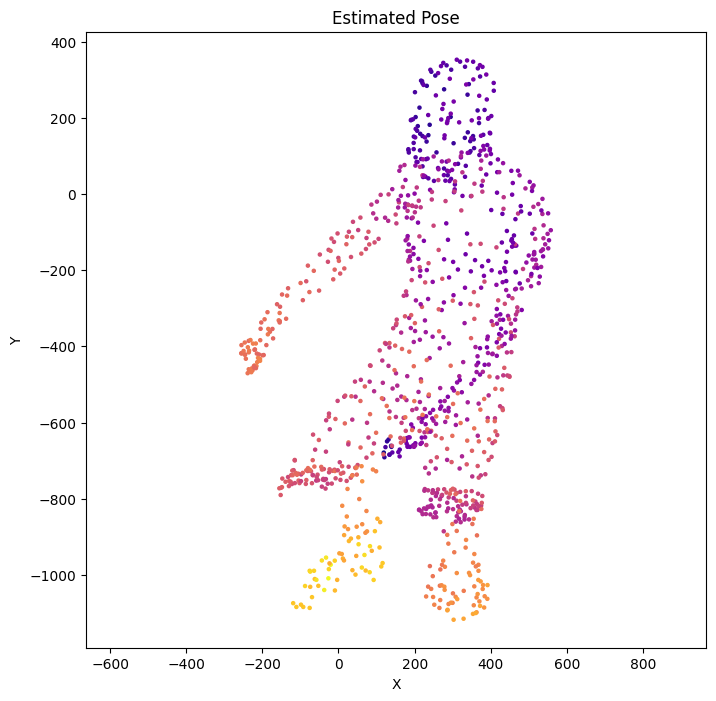

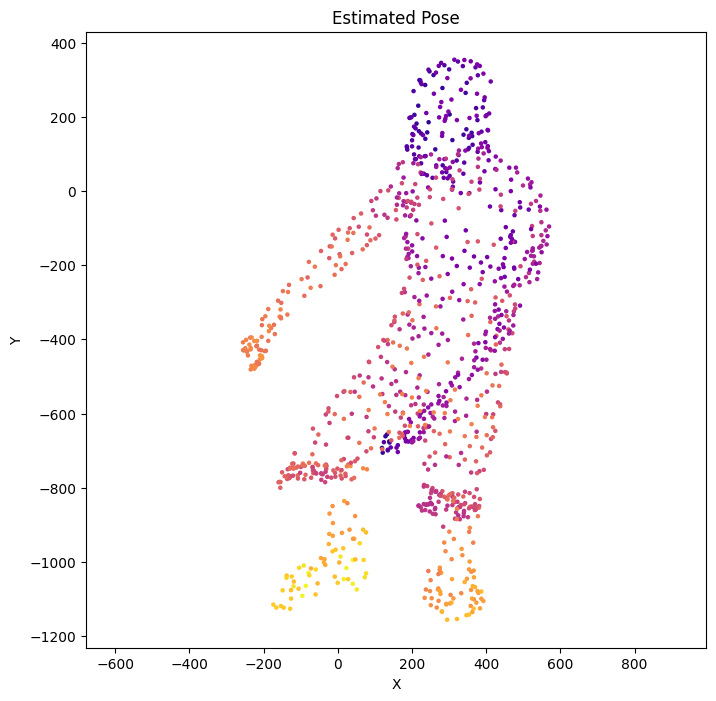

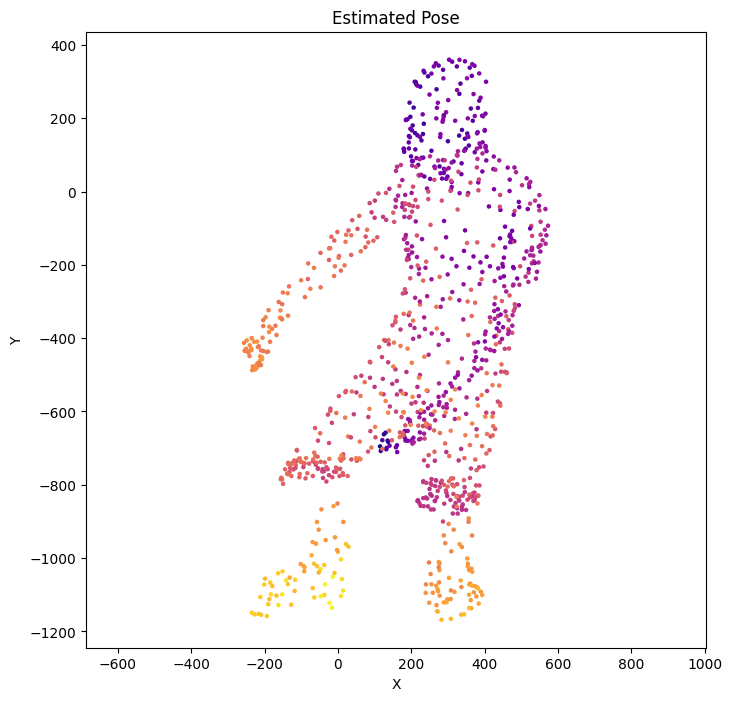

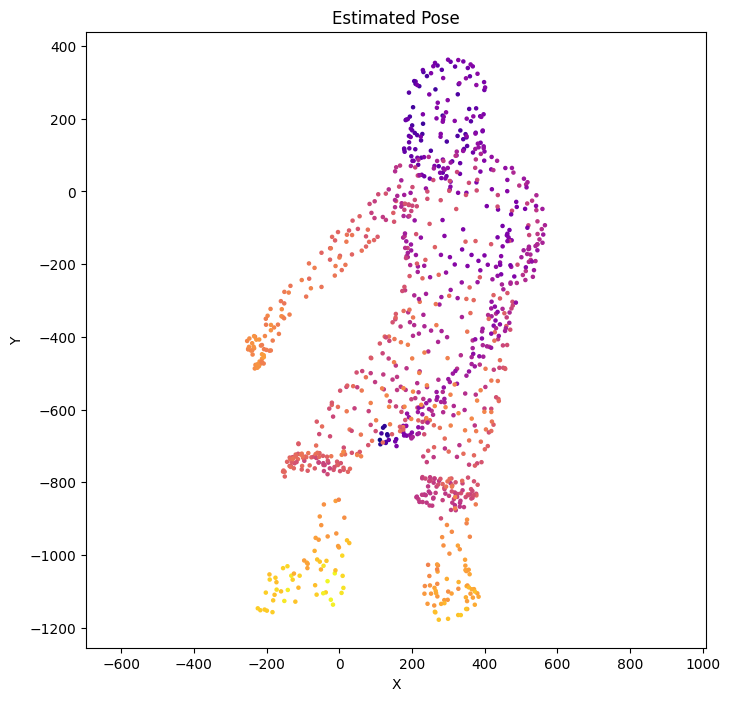

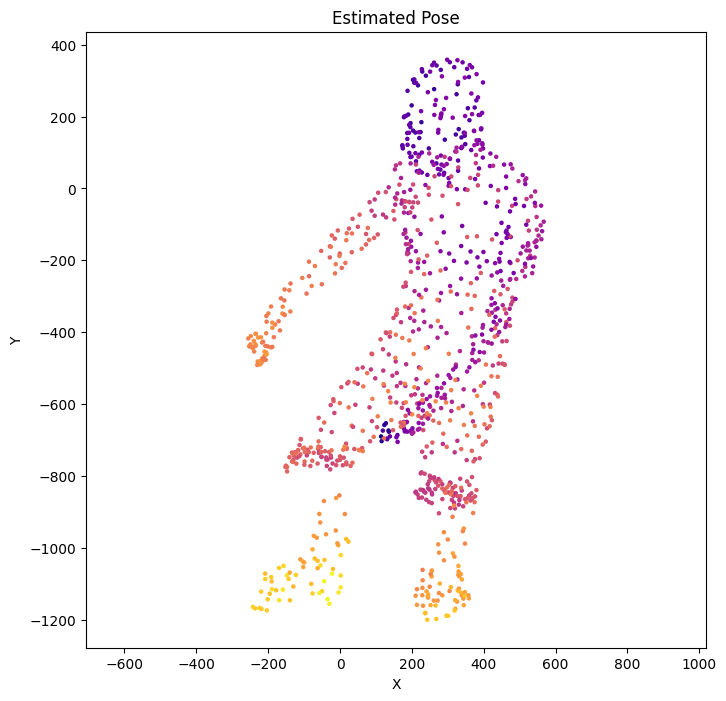

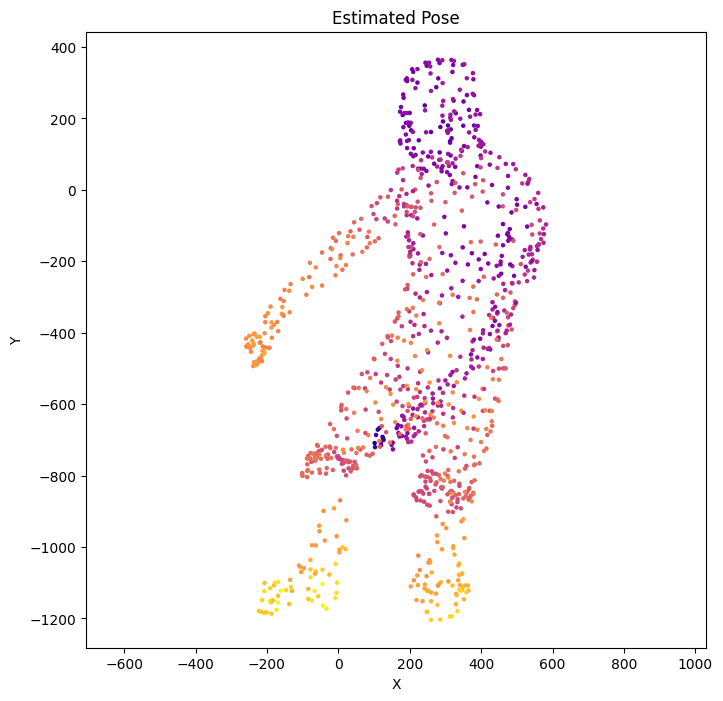

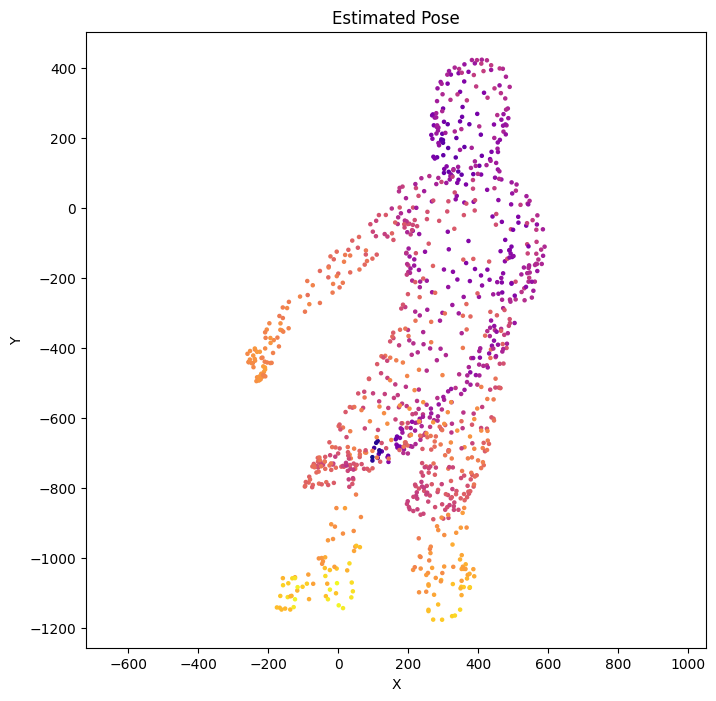

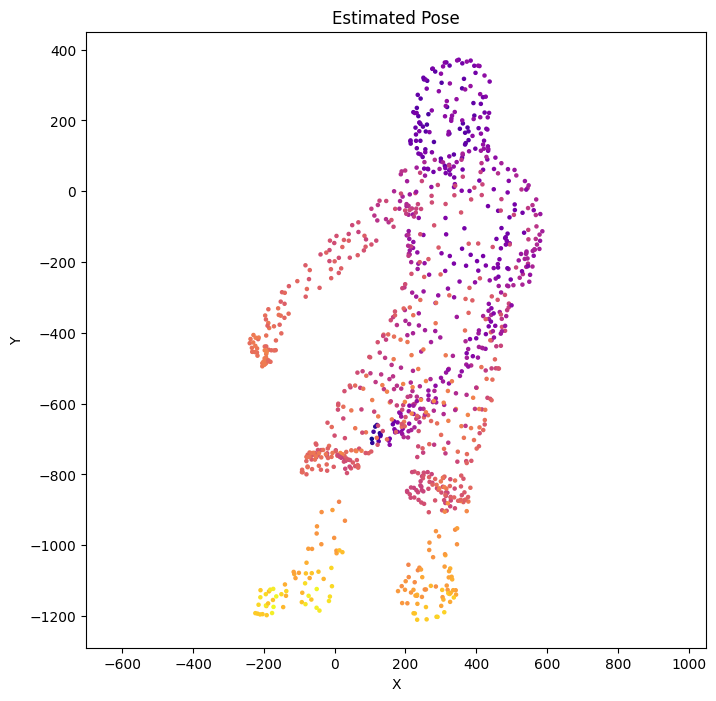

In [3]:

# Load images once
input_file = '/content/processed_images.pkl'
with open(input_file, 'rb') as f:
    imgs = pickle.load(f)

# Initialize figure and scatter plot for animation
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title("Estimated Pose")
sc = ax.scatter([], [], s=5, c=[], cmap='plasma', alpha=1.0)
ax.set_xlim(-2, 2)  # Adjust according to your data
ax.set_ylim(-2, 2)  # Adjust according to your data
ax.set_aspect('equal')

# Function to update the scatter plot for each frame
def update_frame(i):
    img = imgs[i]
    image = torch.from_numpy(img).permute(2, 0, 1).float().cuda()  # Shape: (C, H, W)
    frame_batch = image.unsqueeze(0)

    with torch.no_grad(), torch.device('cuda'):
        pred = model.detect_smpl_batched(frame_batch)

    # Extract vertices (3D joint positions)
    vertices_list = pred['vertices3d_nonparam']
    vertices_tensor = torch.stack(vertices_list)  # Shape: (1, 2, 1024, 3)
    vertices_tensor = vertices_tensor.squeeze(0)[0]  # Remove batch dim and select first set: (1024, 3)
    vertices_numpy = vertices_tensor.cpu().detach().numpy()
    x = vertices_numpy[:, 0]
    y = vertices_numpy[:, 1]
    z = vertices_numpy[:, 2]
    y = -y  # Flip Y-axis if needed

    # Compute the distance of each point from the origin (0, 0, 0)
    distances = np.sqrt(x**2 + y**2 + z**2)

    # Create a colormap based on distances
    plt.figure(figsize=(8, 8))

    # Increase the point size and adjust the alpha for better visibility
    sc = plt.scatter(x, y, s=5, c=distances, cmap='plasma', alpha=1.0)

    # Add a color bar to show the mapping from distance to color
    #plt.colorbar(sc, label='Distance from Origin')

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Estimated Pose")

    # Set equal aspect ratio for the plot to ensure the points are not distorted
    plt.axis('equal')
    print(f"Processing frame {i + 1}/{len(imgs)}")
    return sc,

# Loop through frames and keep track of them
frames = []
for i in range(len(imgs)):
    update_frame(i)  # Update for current frame
    # Save the plot for the current frame
    plt.savefig(f'frame_{i}.png', dpi=150)
    frames.append(f'frame_{i}.png')

# Create an animated gif by combining saved frames
import imageio
with imageio.get_writer('pose_animation.gif', mode='I', duration=0.1) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)

# Optionally, remove the frame images after creating the gif
for frame in frames:
    os.remove(frame)

print("GIF saved as pose_animation.gif")


In [ ]:
vertices_list = pred['vertices3d_nonparam']

# Convert list to tensor and get desired shape
vertices_tensor = torch.stack(vertices_list)  # Shape: (1, 2, 1024, 3)
vertices_tensor = vertices_tensor.squeeze(0)[0]  # Remove batch dim and select first set: (1024, 3)

# Convert to NumPy
vertices_numpy = vertices_tensor.cpu().detach().numpy()
print(vertices_numpy.shape)  # (1024, 3)


print("Point cloud saved to '/mnt/data/point_cloud.ply'")